In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#尚未运行过epoch=600, batch=50

Mounted at /content/drive


In [1]:
import torch
import numpy as np

train_on_gpu=torch.cuda.is_available()

from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

number_of_workers = 0
batch_size= 50
valid_size= 0.2

#  Converting Data into a Normalized Tensor format
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std= (0.5, 0.5, 0.5))
])

train_data= datasets.CIFAR10('data', train= True, download= True, transform = transform)
test_data = datasets.CIFAR10('data', train = False, download = True, transform= transform)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
# Obtaining training Indices that we are going to use for Validation Set
num_train= len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
# 打乱索引顺序
split = int(np.floor(valid_size * num_train))
# 划分训练和验证
train_idx, valid_idx = indices[split:] , indices[:split]
# Defining samplers for training and validation Bathces
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
# Preparing Data Loader for all three sets (combining datasets and samplers)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size ,
                                           sampler= train_sampler , num_workers = number_of_workers)
valid_loader= torch.utils.data.DataLoader(train_data , batch_size= batch_size,
                                          sampler = valid_sampler, num_workers = number_of_workers)
test_loader= torch.utils.data.DataLoader(test_data, batch_size= batch_size,
                                         num_workers= number_of_workers)

class_names =['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 2 , padding=1, stride= 1) # (32 - 5+ 2(0) / 1) + 1 = 28
        self.pool1 = nn.MaxPool2d(2, 2) # (28 - 2 + 2(0)/ 2) + 1 = 14
        self.conv2 = nn.Conv2d(6, 16, 2, padding=1, stride= 1) # (14 - 5 + 2(0)/ 1) + 1 = 10
        self.pool2 = nn.MaxPool2d(2, 2) # (10 - 2 + 2(0)/ 2) + 1 = 5
        self.conv3 = nn.Conv2d(16, 32, 2)# (5 - 2 + 2(0)/ 1) + 1 = 4
        self.pool3 = nn.MaxPool2d(2, 2)# (4 - 2 + 2(0)/ 2) + 1 = 2
        self.fc1 = nn.Linear(32* 3**2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool1( F.relu(self.conv1(x)))
        x= self.pool2( F.relu(self.conv2(x)))
        x= self.pool3(F.relu(self.conv3(x)))
        # Flatten it
        x= torch.flatten(x, 1)
        # x = x.view(x.size(0), -1)
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= self.fc3(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=288, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Epoch: 1 	Training Loss: 1.843875 	Validation Loss: 0.460898
Validation loss decreased (inf --> 0.460898).  Saving model ...
Epoch: 2 	Training Loss: 1.843503 	Validation Loss: 0.460817
Validation loss decreased (0.460898 --> 0.460817).  Saving model ...
Epoch: 3 	Training Loss: 1.843184 	Validation Loss: 0.460755
Validation loss decreased (0.460817 --> 0.460755).  Saving model ...
Epoch: 4 	Training Loss: 1.842934 	Validation Loss: 0.460704
Validation loss decreased (0.460755 --> 0.460704).  Saving model ...
Epoch: 5 	Training Loss: 1.842729 	Validation Loss: 0.460663
Validation loss decreased (0.460704 --> 0.460663).  Saving model ...
Epoch: 6 	Training Loss: 1.842564 	Validation Loss: 0.460629
Validation loss decreased (0.460663 --> 0.460629).  Saving model ...
Epoch: 7 	Training Loss: 1.842427 	Validation Loss: 0.460605
Validation loss decreased (0.460629 --> 0.460605).  Saving model ...
Epoch: 8 	Training Loss: 1.842314 	Validation Loss: 0.460577
Validation loss decreased (0.46060

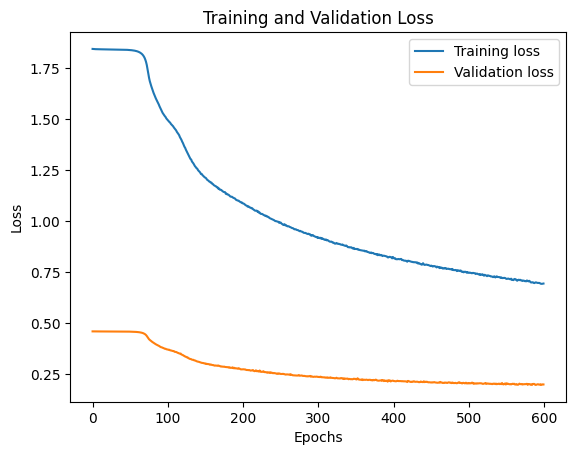

In [4]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
#SGD
optimizer = optim.SGD(model.parameters(), lr= 0.0001, momentum= 0.9)

#Adam
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

# number of epochs to train the model
n_epochs = 600  # you may increase this number to train a final model

valid_loss_min = np.Inf  # track change in validation loss


train_losses = []
valid_losses = []


for epoch in range(1, n_epochs + 1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item() * data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item() * data.size(0)

    # # calculate average losses
    # train_loss = train_loss / len(train_loader.dataset)
    # valid_loss = valid_loss / len(valid_loader.dataset)
    #
    # # print training/validation statistics
    # print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    #     epoch, train_loss, valid_loss))

    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))


    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [5]:
model.load_state_dict(torch.load('model_cifar.pt'))

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

y_true = []
y_pred = []


model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)


    y_true.extend(target.cpu().numpy())
    y_pred.extend(pred.cpu().numpy())
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            class_names[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_names[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.001667

Test Accuracy of airplane: 69% (691/1000)
Test Accuracy of automobile: 78% (789/1000)
Test Accuracy of  bird: 55% (553/1000)
Test Accuracy of   cat: 44% (444/1000)
Test Accuracy of  deer: 58% (583/1000)
Test Accuracy of   dog: 54% (549/1000)
Test Accuracy of  frog: 77% (779/1000)
Test Accuracy of horse: 73% (737/1000)
Test Accuracy of  ship: 74% (747/1000)
Test Accuracy of truck: 70% (701/1000)

Test Accuracy (Overall): 65% (6573/10000)


<Figure size 640x480 with 0 Axes>

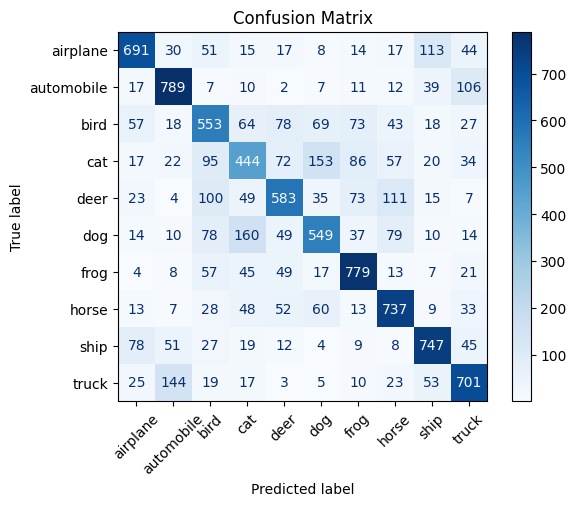

In [6]:
# Increase the size of the confusion matrix display
plt.figure()

confusionM = confusion_matrix(y_true, y_pred)
displayCM = ConfusionMatrixDisplay(confusion_matrix=confusionM, display_labels=class_names)

# Use a different colormap
displayCM.plot(cmap=plt.cm.Blues)  # You can change Greens to any other colormap like Reds, Blues, etc.

plt.title("Confusion Matrix")
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Rotate the x-axis labels so they don't overlap
plt.xticks(rotation=45)

plt.show()

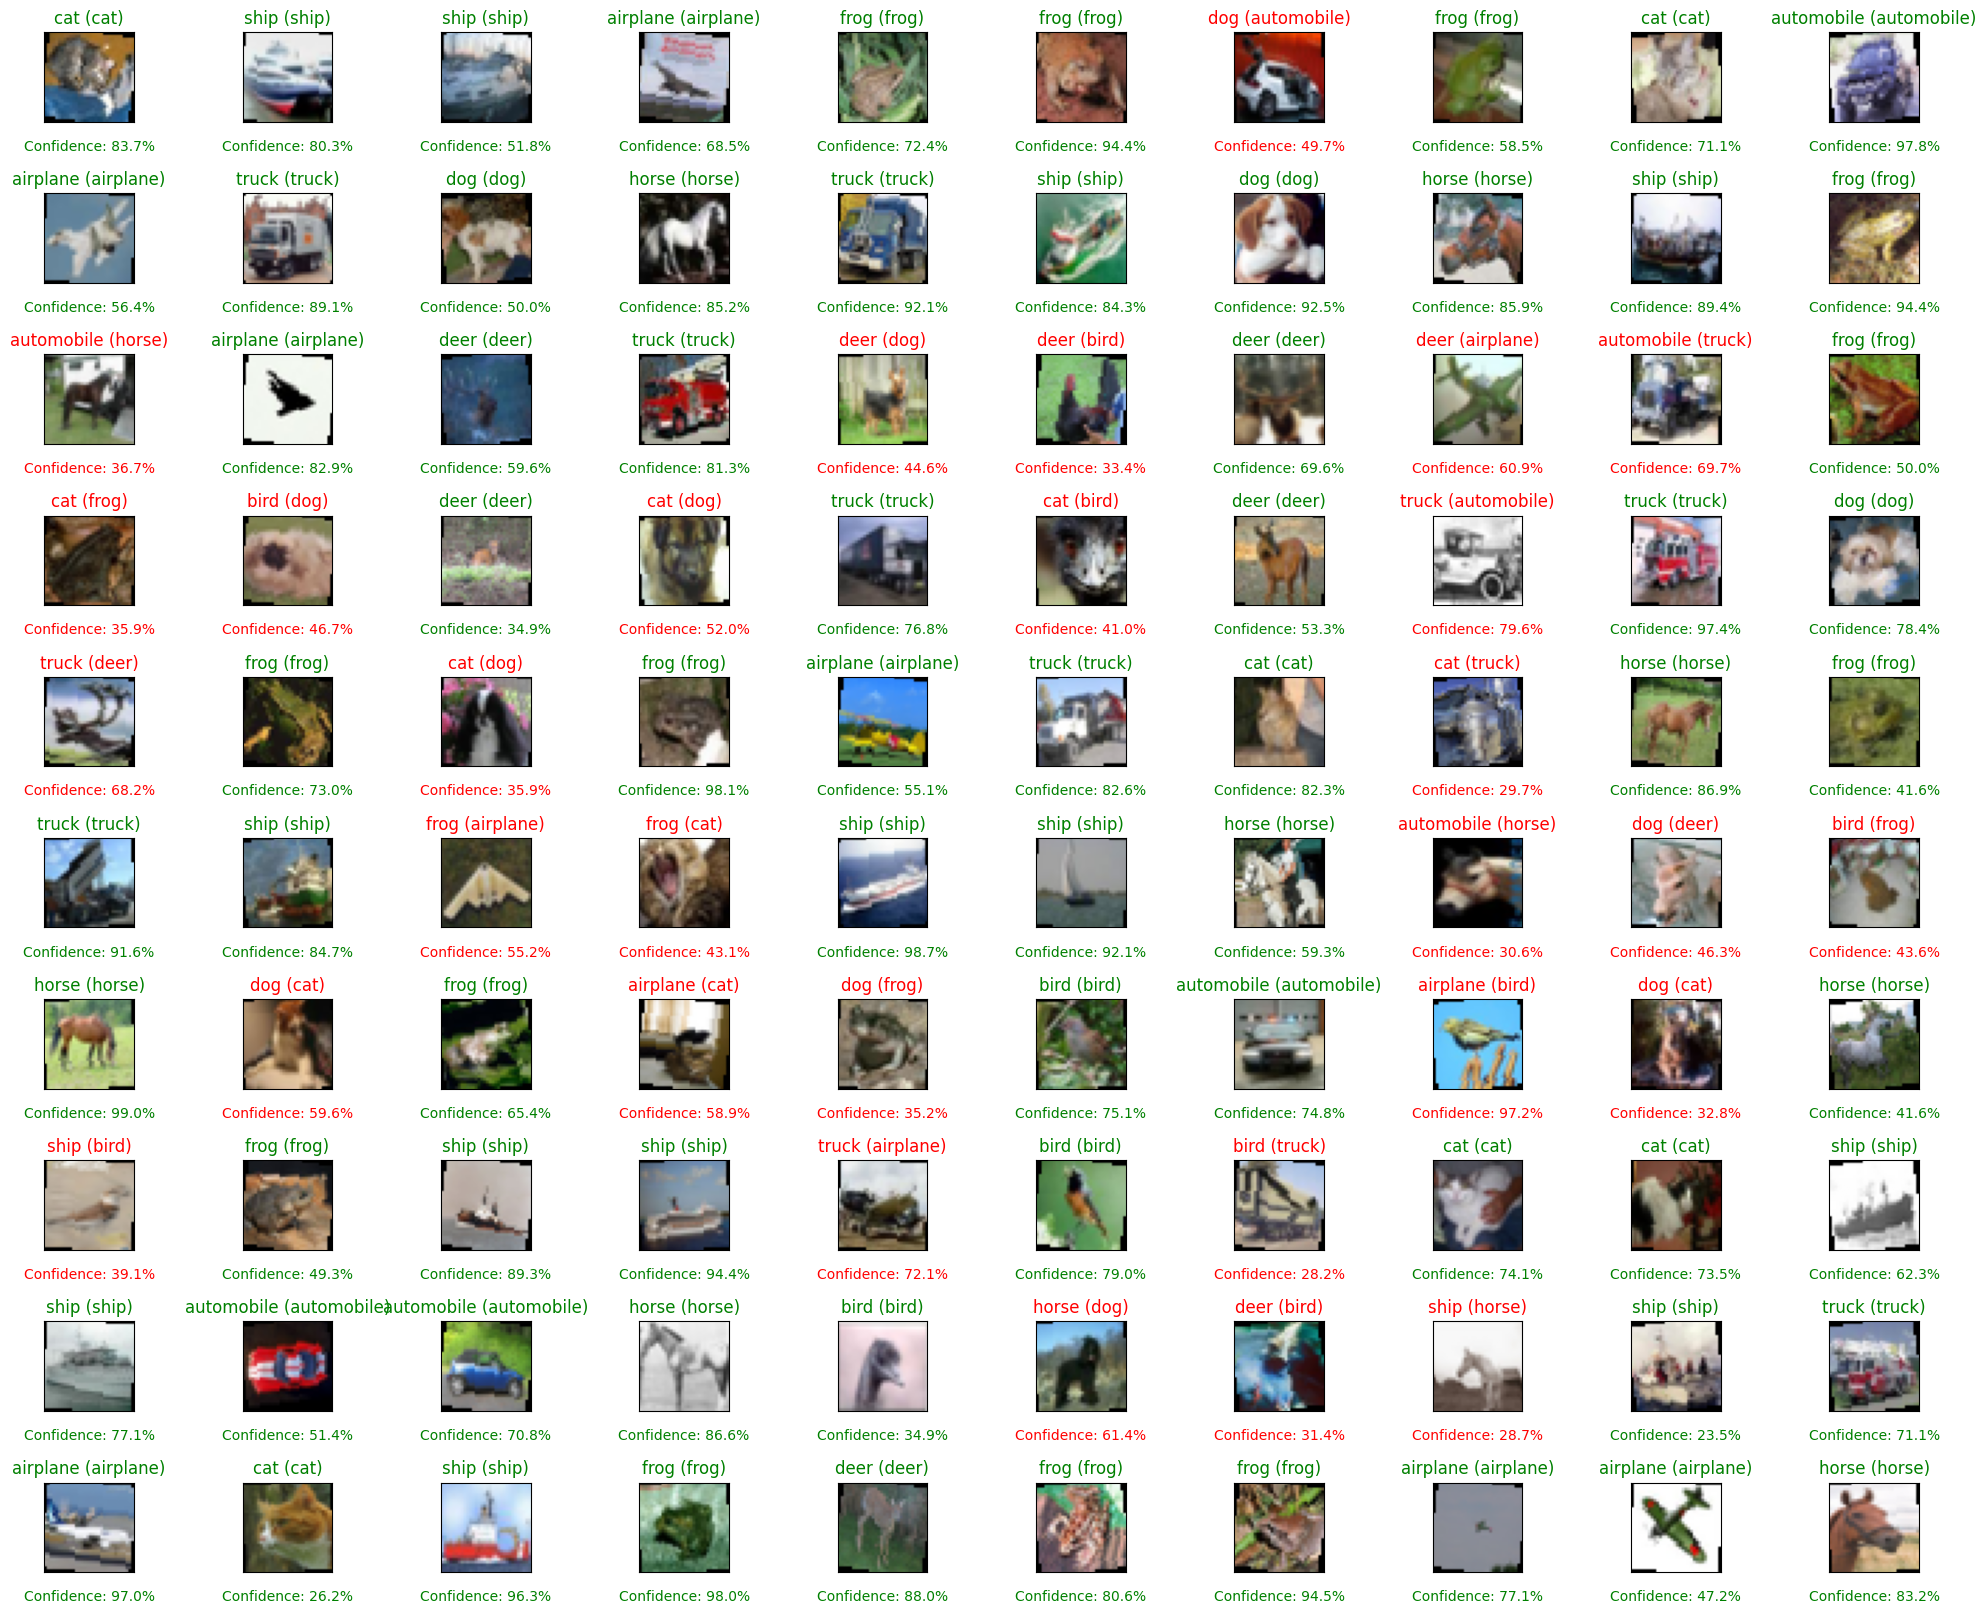

In [7]:
new_test_loader= torch.utils.data.DataLoader(test_data, batch_size= 100,
                                         num_workers= number_of_workers)

#draw the classified imgaes result and confidence
def imshow(img):
    img = img / 2 + 0.5  # unnormalize if the images were normalized
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from tensor image

# Obtain one batch of test images
dataiter = iter(new_test_loader)
images, labels = next(dataiter)

# Move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# Get sample outputs
output = model(images)
# Convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy())

# Get the probabilities for the predictions
probabilities = torch.nn.functional.softmax(output, dim=1)
confidences = np.max(probabilities.cpu().detach().numpy(), axis=1)

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 20))
for idx in np.arange(100):
    ax = fig.add_subplot(10, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())  # Use your image display function here
    title_color = "green" if preds[idx]==labels[idx].item() else "red"
    # Set the title with class names
    ax.set_title("{0} ({1})".format(class_names[preds[idx]], class_names[labels[idx]]), color=title_color)
    # Set the confidence below the image
    ax.text(0.5, -0.2, "Confidence: {0:.1f}%".format(confidences[idx]*100),
            ha='center', va='top', transform=ax.transAxes, color=title_color)
    # Adjust the subplot parameters to give specified padding
    plt.subplots_adjust(hspace=0.8, wspace=0.3)
plt.show()
